In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader


In [19]:
def CNN_BiLSTM_AM_pred(filename):
    # Load the data
    df = pd.read_csv('data/'+filename+'.csv')

    # Preprocess the data

    close_scaler = MinMaxScaler(feature_range=(0, 1))
    close_prices = df[['close']].values  # Assuming 'Close' is the column name for close prices
    close_scaler.fit(close_prices)  # Fit the scaler on close prices only

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[df.columns[2:]])

    # Create dataset with look-back
    def create_dataset(data, look_back=10):
        dataX, dataY = [], []
        for i in range(len(data)-look_back-1):
            a = data[i:(i+look_back), :]
            dataX.append(a)
            dataY.append(data[i + look_back, 3])  # index 3 is the 'close' value
        return np.array(dataX), np.array(dataY)

    look_back = 10
    X, y = create_dataset(scaled_data, look_back)

    # Split into train and test sets
    train_size = int(len(X) * 0.95)
    test_size = len(X) - train_size
    trainX, testX = X[:train_size], X[train_size:]
    trainY, testY = y[:train_size], y[train_size:]

    # Convert to Tensors
    trainX = torch.tensor(trainX).float()
    trainY = torch.tensor(trainY).float().view(-1, 1)
    testX = torch.tensor(testX).float()
    testY = torch.tensor(testY).float().view(-1, 1)

    # Create DataLoaders
    batch_size = 64
    train_data = TensorDataset(trainX, trainY)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

    test_data = TensorDataset(testX, testY)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

    # Define the CNN-BiLSTM-AM Model
    class CNNBiLSTMAM(nn.Module):
        def __init__(self, num_features, hidden_size, seq_length, num_layers=1):
            super(CNNBiLSTMAM, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.seq_length = seq_length

            # CNN layer
            self.conv1d = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1)
            self.relu = nn.ReLU()

            # Bidirectional LSTM layer
            self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=num_layers,
                                batch_first=True, bidirectional=True)

            # Attention mechanism
            self.attention = nn.Linear(hidden_size * 2, seq_length)
            self.softmax = nn.Softmax(dim=1)

            # Fully connected layer
            self.fc = nn.Linear(hidden_size * 2 * seq_length, 1)

        def forward(self, x):
            x = x.transpose(1, 2)
            x = self.relu(self.conv1d(x))
            x = x.transpose(1, 2)

            lstm_out, _ = self.lstm(x)

            # Apply attention
            attention_weights = self.softmax(self.attention(lstm_out).transpose(1, 2))
            attention_output = torch.bmm(attention_weights, lstm_out)

            # Flatten the output
            attention_output = attention_output.contiguous().view(attention_output.size(0), -1)

            # Fully connected layer
            out = self.fc(attention_output)
            return out

    # Instantiate the model
    num_features = trainX.shape[2]
    hidden_size = 64
    seq_length = look_back
    num_layers = 2

    model = CNNBiLSTMAM(num_features, hidden_size, seq_length, num_layers)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Enable GPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Train the model
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for dataX, dataY in train_loader:
            dataX = dataX.to(device)
            dataY = dataY.to(device)

            outputs = model(dataX)
            optimizer.zero_grad()
            loss = criterion(outputs, dataY)
            loss.backward()
            optimizer.step()

        # Validation loss
        model.eval()
        val_losses = []
        with torch.no_grad():
            for dataX, dataY in test_loader:
                dataX = dataX.to(device)
                dataY = dataY.to(device)
                outputs = model(dataX)
                val_loss = criterion(outputs, dataY)
                val_losses.append(val_loss.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {np.mean(val_losses)}')

    # Evaluate the model
    model.eval()
    test_predictions = []
    test_actual = []
    with torch.no_grad():
        for dataX, dataY in test_loader:
            dataX = dataX.to(device)
            dataY = dataY.to(device)
            outputs = model(dataX)
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_actual.extend(dataY.cpu().numpy().flatten())

    test_predictions = np.array(test_predictions)
    test_actual = np.array(test_actual)

    # Rescale the predictions back to the original data scale
    test_predictions = close_scaler.inverse_transform(np.expand_dims(test_predictions, axis=1))
    test_actual = close_scaler.inverse_transform(np.expand_dims(test_actual, axis=1))

    # Calculate MAE, RMSE, and R-squared
    mae = mean_absolute_error(test_actual, test_predictions)
    rmse = np.sqrt(mean_squared_error(test_actual, test_predictions))
    r2 = r2_score(test_actual, test_predictions)

    print(f'Test MAE: {mae}')
    print(f'Test RMSE: {rmse}')
    print(f'Test R2: {r2}')

    # Plot the results
    plt.figure(figsize=(12,6))
    plt.plot(test_actual, label='Actual Close Price')
    plt.plot(test_predictions, label='Predicted Close Price')
    plt.title('Actual vs Predicted Close Prices')
    plt.xlabel('Time')
    plt.ylabel('AAPL Stock Price')
    plt.legend()
    plt.savefig('CNN_BiLSTM_AM_'+filename+'.png')
    return mae, rmse, r2

Epoch 1/10, Loss: 3.957599983550608e-05, Validation Loss: 0.001130964228650555
Epoch 2/10, Loss: 5.325655365595594e-06, Validation Loss: 0.0014269228777266107
Epoch 3/10, Loss: 4.899566192761995e-06, Validation Loss: 0.0008937253660405986
Epoch 4/10, Loss: 2.2138512576930225e-05, Validation Loss: 0.001221534243086353
Epoch 5/10, Loss: 2.2804813852417283e-05, Validation Loss: 0.0037935671425657347
Epoch 6/10, Loss: 5.54310463485308e-05, Validation Loss: 0.0018945442934636958
Epoch 7/10, Loss: 4.500999057199806e-05, Validation Loss: 0.0007147921860450879
Epoch 8/10, Loss: 2.9924583941465244e-05, Validation Loss: 0.0009273067807953339
Epoch 9/10, Loss: 7.956335321068764e-05, Validation Loss: 0.0008274856954813004
Epoch 10/10, Loss: 5.715896804758813e-06, Validation Loss: 0.0011707488738466054
Test MAE: 5.3675127029418945
Test RMSE: 6.7200927734375
Test R2: 0.8263597687459349
Epoch 1/10, Loss: 0.0005892956396564841, Validation Loss: 2.2425926241946097e-05
Epoch 2/10, Loss: 0.00026810413692

Epoch 4/10, Loss: 0.00017368215776514262, Validation Loss: 0.0012223547091707587
Epoch 5/10, Loss: 7.269837078638375e-05, Validation Loss: 0.0008375367382541299
Epoch 6/10, Loss: 0.00014818573254160583, Validation Loss: 0.000832211785018444
Epoch 7/10, Loss: 0.0001865667727543041, Validation Loss: 0.0006894842779729515
Epoch 8/10, Loss: 0.00015186613018158823, Validation Loss: 0.0007112763763871044
Epoch 9/10, Loss: 0.0004868371179327369, Validation Loss: 0.0008065060887020081
Epoch 10/10, Loss: 0.0001720540167298168, Validation Loss: 0.0008401993662118911
Test MAE: 3.275498151779175
Test RMSE: 3.987860679626465
Test R2: 0.8525358209863421


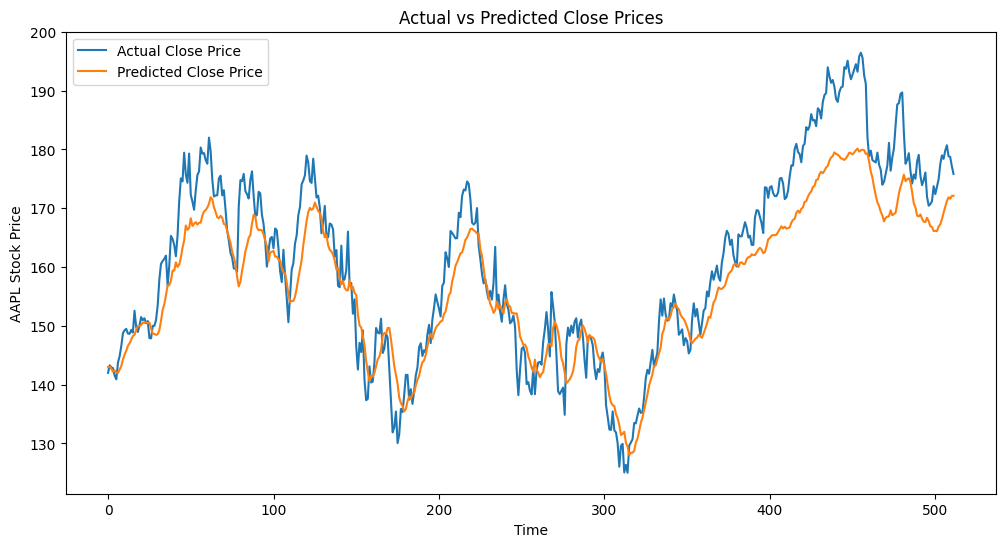

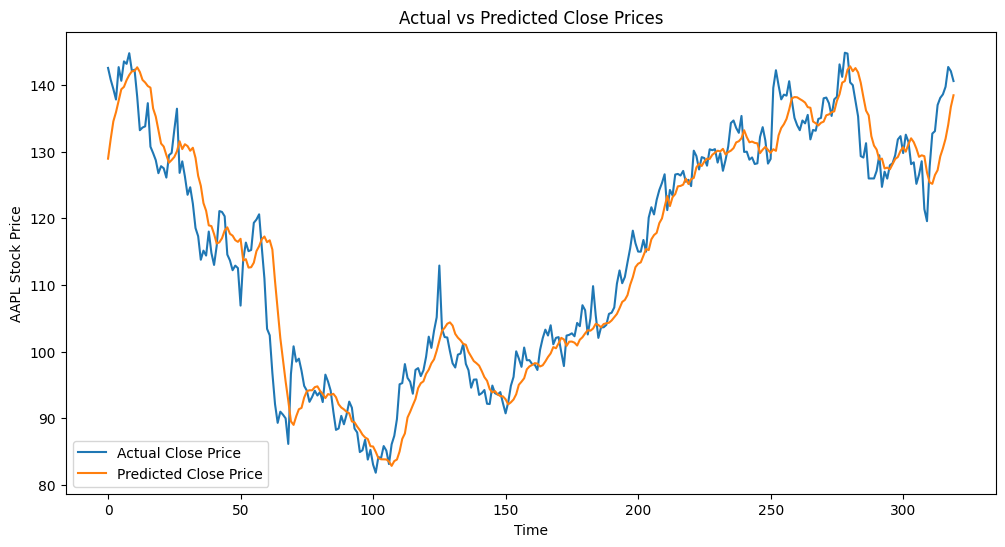

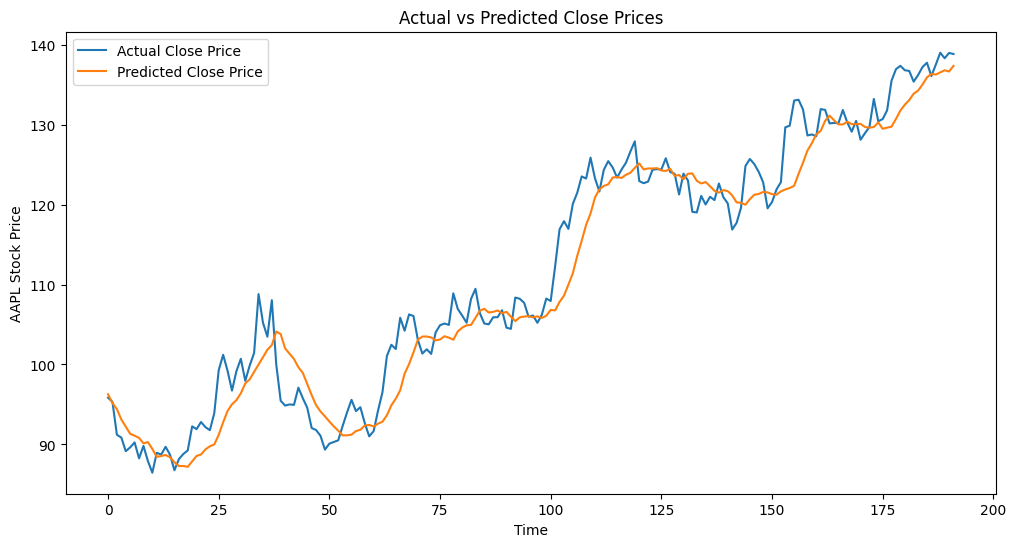

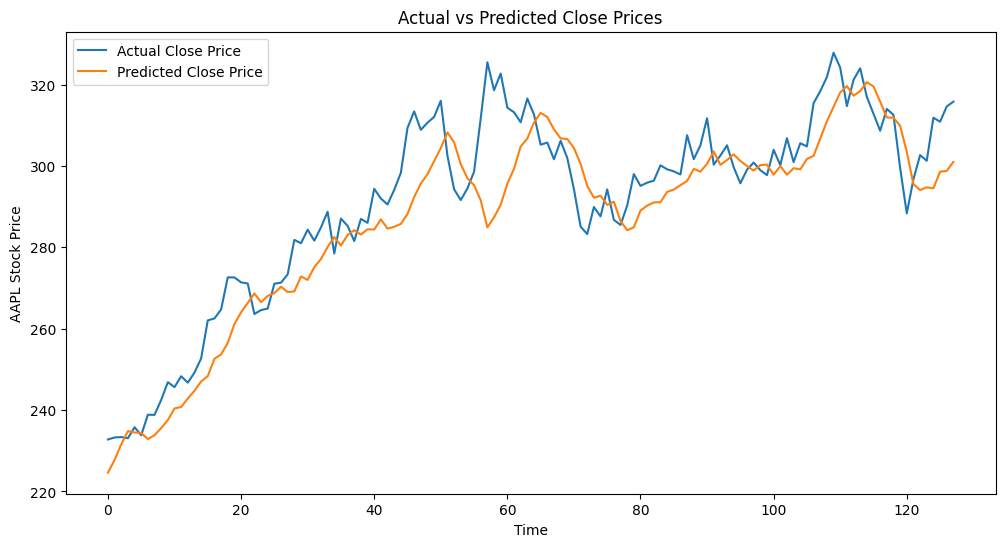

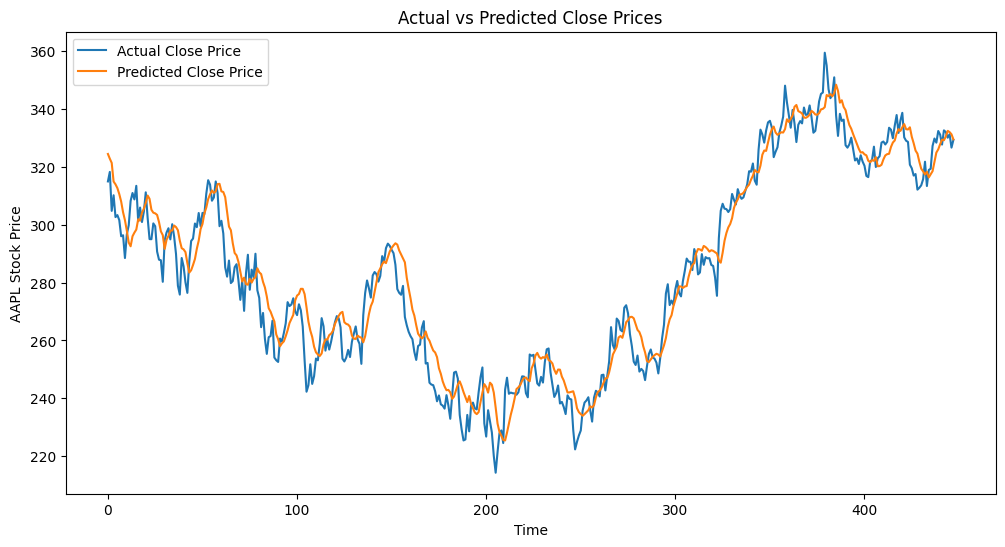

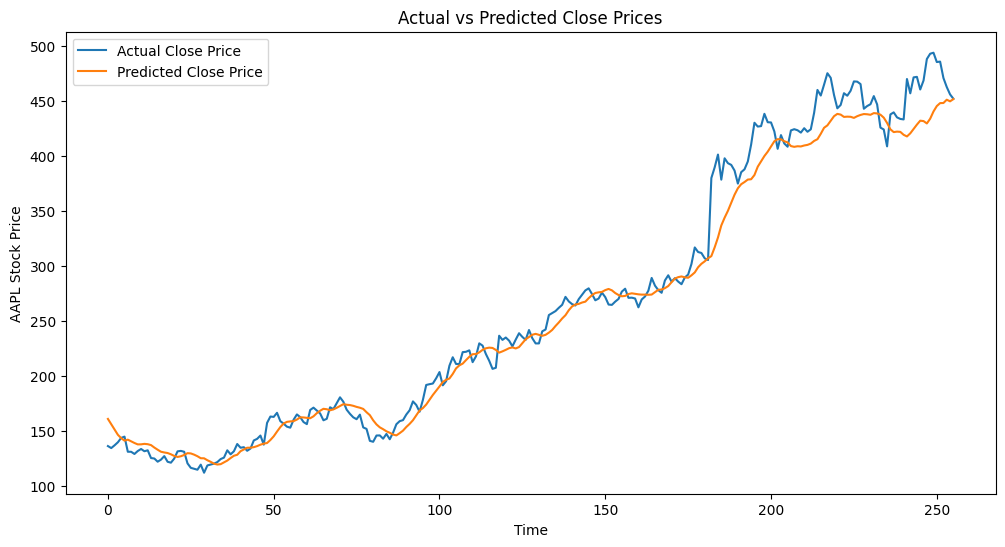

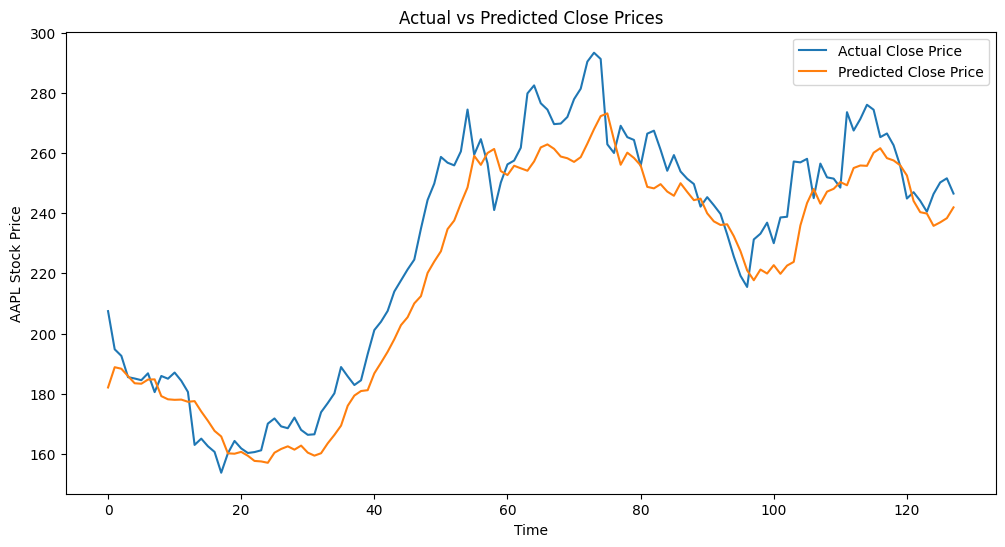

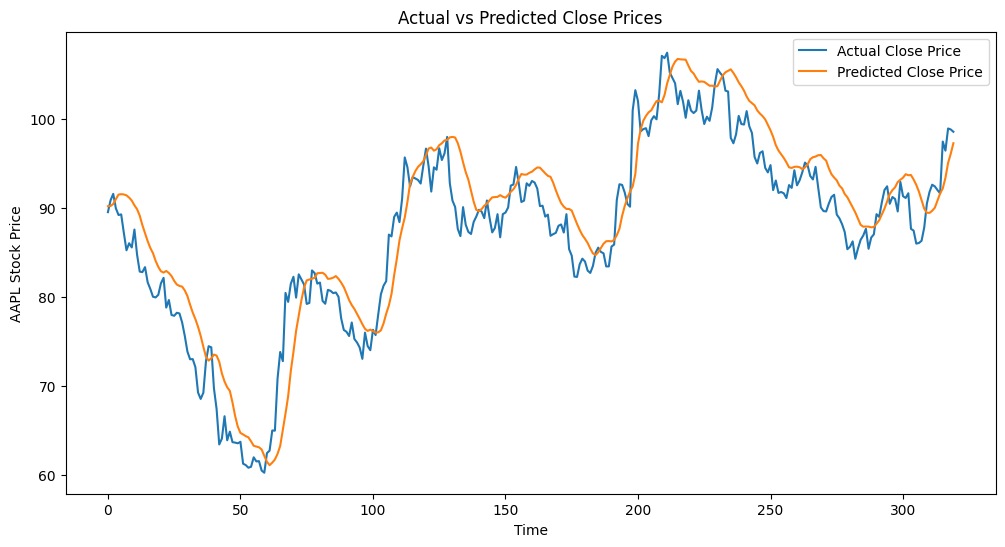

In [20]:
filenames = ['AAPL', 'AMSC', 'AMZN', 'GOOG', 'INTC', 'META', 'MSFT', 'NVDA', 'TSLA', 'TSM']
maes = []
rmses = []
r2s = []
for f in filenames[:]:
    x,y,z = CNN_BiLSTM_AM_pred(f)
    maes.append(x)
    rmses.append(y)
    r2s.append(z)

In [27]:
print(np.array(maes).mean())
print(np.array(rmses).mean())
print(np.array([i for i in r2s if i > 0]).mean())

5.7160945
7.65942
0.9024840182861242
